MULTI-OUTPUT RANDOM FOREST MODEL - FINAL VERSION

One model predicting all 4 targets: SAI 7d, 28d, 56d, 90d
Using ALL features including 'Remarks'

1. Loading Data...
   ✓ Original: 32 samples
   ✓ Synthetic: 320 samples

   Remarks column values:
   Original: ['PC' 'PLC']
   Synthetic: ['PC' 'PLC']

2. Encoding Categorical Variable 'Remarks'...
   ✓ Encoded 'Remarks': {'PC': 0, 'PLC': 1}

3. Adding Measurement Noise to Synthetic Data...
   ✓ Added 15.0% noise to continuous features (increased for realism)
   ✓ Categorical features unchanged: GP, FBC, FA, VA, SC, CC, GBA, Remarks
   ℹ Higher noise simulates real-world measurement uncertainty

4. Preparing Data...
   ✓ Combined dataset: 352 samples

   Features used (16 total):
      1. GP
      2. FBC
      3. FA
      4. VA
      5. SC
      6. CC
      7. GBA
      8. Remarks_Encoded
      9. D10
      10. D50
      11. D90
      12. Amorphous content
      13. Heat Release
      14. Bound Water
      15. CH Consumption
      16. W/C

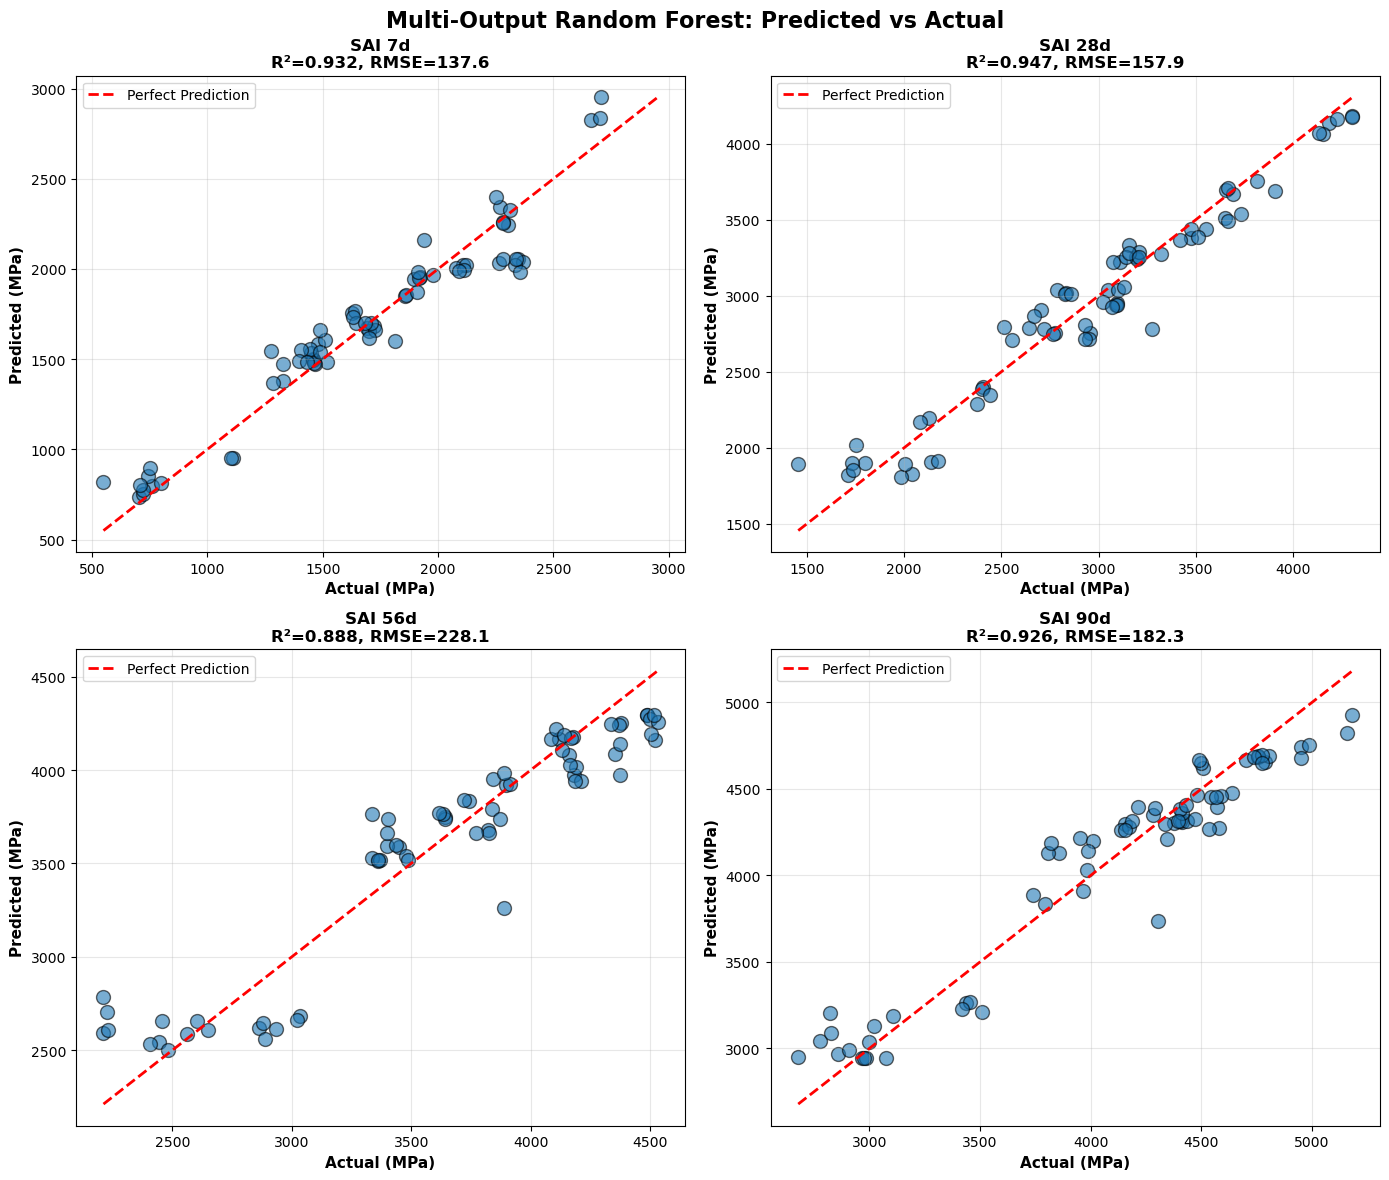

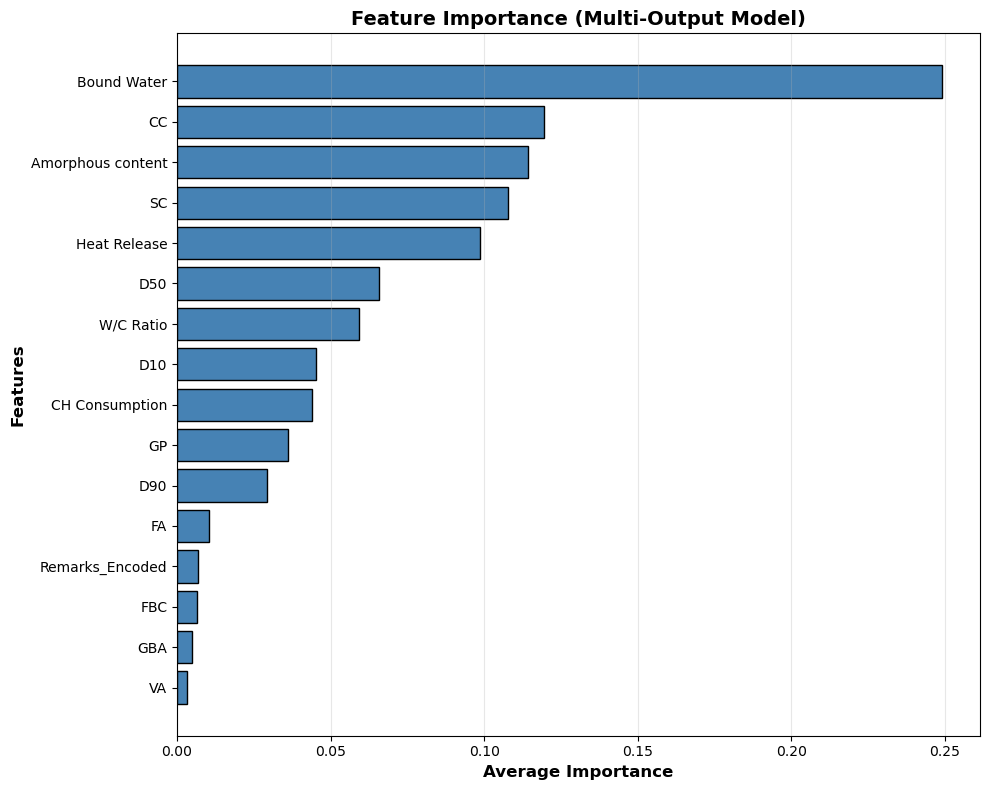

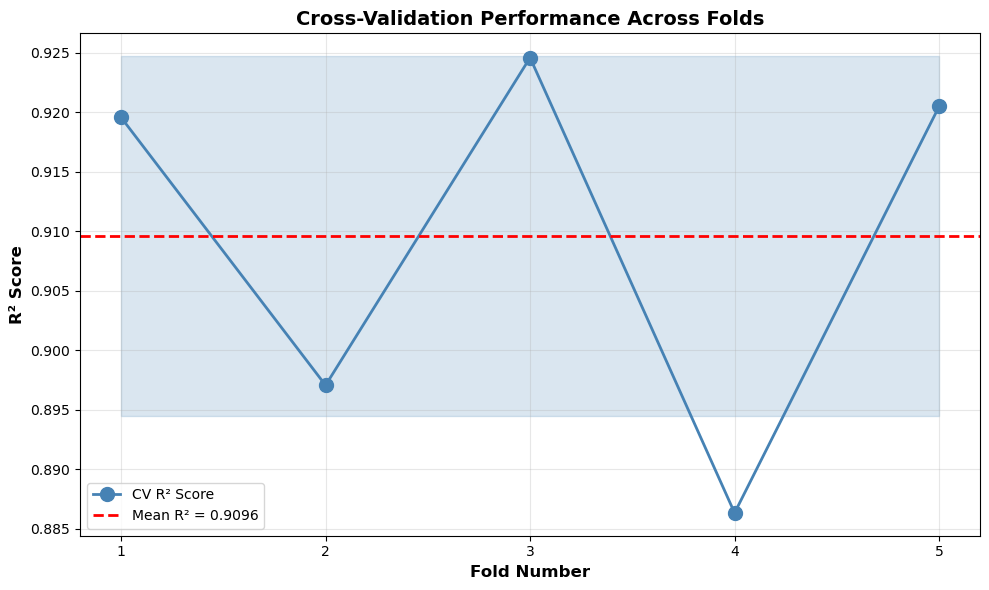

In [5]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("="*80)
print("MULTI-OUTPUT RANDOM FOREST MODEL - FINAL VERSION")
print("="*80)
print("\nOne model predicting all 4 targets: SAI 7d, 28d, 56d, 90d")
print("Using ALL features including 'Remarks'")
print("="*80)

FEATURES = [
    'GP', 'FBC', 'FA', 'VA', 'SC', 'CC', 'GBA', 'Remarks',
    'D10 ', 'D50 ', 'D90 ', 'Amorphous content ',
    'Heat Release', 'Bound Water', 'CH Consumption', 'W/C Ratio'
]
TARGETS = ['SAI 7d', 'SAI 28d', 'SAI 56d', 'SAI 90d']


MODEL_PARAMS = {
    'n_estimators': 80,        
    'max_depth': 10,             
    'min_samples_split': 15,    
    'min_samples_leaf': 8,      
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

NOISE_LEVEL = 0.15  
print("\n1. Loading Data...")
original = pd.read_excel('/Users/sayedmahdi/Desktop/MyFolder/Practice/self_practicing/ML/Book1.xlsx')
synthetic = pd.read_csv('/Users/sayedmahdi/Desktop/MyFolder/Practice/self_practicing/ML/synthetic_data_320.csv')
print(f"   ✓ Original: {len(original)} samples")
print(f"   ✓ Synthetic: {len(synthetic)} samples")
print(f"\n   Remarks column values:")
print(f"   Original: {original['Remarks'].unique()}")
print(f"   Synthetic: {synthetic['Remarks'].unique()}")
print("\n2. Encoding Categorical Variable 'Remarks'...")
combined_temp = pd.concat([original, synthetic], ignore_index=True)
label_encoder = LabelEncoder()
combined_temp['Remarks_Encoded'] = label_encoder.fit_transform(combined_temp['Remarks'])
print(f"   ✓ Encoded 'Remarks': {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
original_encoded = combined_temp.iloc[:len(original)].copy()
synthetic_encoded = combined_temp.iloc[len(original):].copy().reset_index(drop=True)
FEATURES_ENCODED = [
    'GP', 'FBC', 'FA', 'VA', 'SC', 'CC', 'GBA', 'Remarks_Encoded',
    'D10 ', 'D50 ', 'D90 ', 'Amorphous content ',
    'Heat Release', 'Bound Water', 'CH Consumption', 'W/C Ratio'
]
print("\n3. Adding Measurement Noise to Synthetic Data...")

synthetic_noisy = synthetic_encoded.copy()
categorical_features = ['GP', 'FBC', 'FA', 'VA', 'SC', 'CC', 'GBA', 'Remarks', 'Remarks_Encoded']

for col in FEATURES_ENCODED:
    if col not in categorical_features:
        std = synthetic_encoded[col].std()
        noise = np.random.normal(0, NOISE_LEVEL * std, size=len(synthetic_encoded))
        synthetic_noisy[col] = synthetic_encoded[col] + noise

print(f"   ✓ Added {NOISE_LEVEL*100}% noise to continuous features (increased for realism)")
print(f"   ✓ Categorical features unchanged: GP, FBC, FA, VA, SC, CC, GBA, Remarks")
print(f"   ℹ Higher noise simulates real-world measurement uncertainty")
print("\n4. Preparing Data...")
combined = pd.concat([synthetic_noisy, original_encoded], ignore_index=True)
print(f"   ✓ Combined dataset: {len(combined)} samples")
X = combined[FEATURES_ENCODED].values
y = combined[TARGETS].values
print(f"\n   Features used ({len(FEATURES_ENCODED)} total):")
for i, feat in enumerate(FEATURES_ENCODED, 1):
    print(f"      {i}. {feat.strip()}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n   ✓ Training set: {len(X_train)} samples")
print(f"   ✓ Test set: {len(X_test)} samples")
print("\n5. Training Multi-Output Random Forest Model...")
print("   (This trains one model that predicts all 4 targets simultaneously)")
base_rf = RandomForestRegressor(**MODEL_PARAMS)
multi_output_model = MultiOutputRegressor(base_rf)
multi_output_model.fit(X_train, y_train)
print("   ✓ Model trained successfully!")
print("\n6. Performing Cross-Validation...")

from sklearn.model_selection import cross_validate
cv_results = cross_validate(
    multi_output_model, 
    X_train, 
    y_train,
    cv=5,
    scoring=['r2', 'neg_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("="*80)
cv_r2_mean = cv_results['test_r2'].mean()
cv_r2_std = cv_results['test_r2'].std()
cv_rmse_mean = np.sqrt(-cv_results['test_neg_mean_squared_error'].mean())
cv_rmse_std = np.sqrt(-cv_results['test_neg_mean_squared_error']).std()

print(f"\nCross-Validation R² Score:")
print(f"   Mean: {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")
print(f"   Individual Folds: {[f'{score:.4f}' for score in cv_results['test_r2']]}")

print(f"\nCross-Validation RMSE:")
print(f"   Mean: {cv_rmse_mean:.2f} MPa (±{cv_rmse_std:.2f})")

print(f"\nTraining R² Score:")
print(f"   Mean: {cv_results['train_r2'].mean():.4f} (±{cv_results['train_r2'].std():.4f})")
train_test_gap = cv_results['train_r2'].mean() - cv_r2_mean
print(f"\nTrain-Test Gap: {train_test_gap:.4f}")
if train_test_gap < 0.05:
    print("    No overfitting detected (gap < 5%)")
elif train_test_gap < 0.10:
    print("   Minor overfitting (gap 5-10%)")
else:
    print("    Significant overfitting detected (gap > 10%)")

print("\n7. Evaluating Model on Test Set...")
y_pred = multi_output_model.predict(X_test)
print("\n" + "="*80)
print("TEST SET PERFORMANCE METRICS")
print("="*80)

results = []
for i, target in enumerate(TARGETS):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    mape = np.mean(np.abs((y_test[:, i] - y_pred[:, i]) / y_test[:, i])) * 100
    
    print(f"\n{target}:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   RMSE: {rmse:.2f} MPa")
    print(f"   MAE: {mae:.2f} MPa")
    print(f"   MAPE: {mape:.2f}%")
    
    results.append({
        'Target': target,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))
avg_r2 = results_df['R²'].mean()
print(f"\n✓ Average Test R² across all targets: {avg_r2:.4f}")
print(f"✓ Average CV R² across all targets: {cv_r2_mean:.4f}")
print(f"✓ Difference (Test - CV): {(avg_r2 - cv_r2_mean):.4f}")
print("\n8. Feature Importance Analysis...")
feature_importance_list = []
for estimator in multi_output_model.estimators_:
    feature_importance_list.append(estimator.feature_importances_)

avg_importance = np.mean(feature_importance_list, axis=0)

importance_df = pd.DataFrame({
    'Feature': [f.strip() for f in FEATURES_ENCODED],
    'Importance': avg_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
for idx, row in importance_df.head(10).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")
print("\n9. Creating Visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Multi-Output Random Forest: Predicted vs Actual', 
             fontsize=16, fontweight='bold')

for i, target in enumerate(TARGETS):
    ax = axes[i // 2, i % 2]
    
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.6, s=100, 
               edgecolors='black', linewidth=1)
    
    # Perfect prediction line
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, 
            label='Perfect Prediction')
    
    r2 = results[i]['R²']
    rmse = results[i]['RMSE']
    
    ax.set_xlabel('Actual (MPa)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted (MPa)', fontsize=11, fontweight='bold')
    ax.set_title(f'{target}\nR²={r2:.3f}, RMSE={rmse:.1f}', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('multi_output_predictions.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: multi_output_predictions.png")
fig, ax = plt.subplots(figsize=(10, 8))
importance_df_plot = importance_df.head(16).sort_values('Importance')

ax.barh(range(len(importance_df_plot)), importance_df_plot['Importance'], 
        color='steelblue', edgecolor='black')
ax.set_yticks(range(len(importance_df_plot)))
ax.set_yticklabels(importance_df_plot['Feature'])
ax.set_xlabel('Average Importance', fontweight='bold', fontsize=12)
ax.set_ylabel('Features', fontweight='bold', fontsize=12)
ax.set_title('Feature Importance (Multi-Output Model)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_multi_output.png', dpi=300, bbox_inches='tight')
print("    Saved: feature_importance_multi_output.png")
fig, ax = plt.subplots(figsize=(10, 6))

fold_numbers = range(1, 6)
ax.plot(fold_numbers, cv_results['test_r2'], 'o-', linewidth=2, 
        markersize=10, label='CV R² Score', color='steelblue')
ax.axhline(y=cv_r2_mean, color='red', linestyle='--', linewidth=2, 
           label=f'Mean R² = {cv_r2_mean:.4f}')
ax.fill_between(fold_numbers, 
                cv_r2_mean - cv_r2_std, 
                cv_r2_mean + cv_r2_std, 
                alpha=0.2, color='steelblue')

ax.set_xlabel('Fold Number', fontweight='bold', fontsize=12)
ax.set_ylabel('R² Score', fontweight='bold', fontsize=12)
ax.set_title('Cross-Validation Performance Across Folds', 
             fontsize=14, fontweight='bold')
ax.set_xticks(fold_numbers)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cross_validation_scores.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: cross_validation_scores.png")
print("\n10. Saving Model and Encoder...")
joblib.dump(multi_output_model, 'multi_output_rf_model.pkl')
joblib.dump(label_encoder, 'remarks_label_encoder.pkl')

print("   Saved: multi_output_rf_model.pkl")
print("    Saved: remarks_label_encoder.pkl")

with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(FEATURES_ENCODED))
print("  Saved: feature_names.txt")
print("\n" + "="*80)
print("EXAMPLE: Making Predictions with New Data")
print("="*80)
example = {
    'GP': 4,
    'FBC': 0,
    'FA': 0,
    'VA': 0,
    'SC': 0,
    'CC': 0,
    'GBA': 1,
    'Remarks': 'PC',  
    'D10 ': 2.1,
    'D50 ': 15.7,
    'D90 ': 50.9,
    'Amorphous content ': 90.7,
    'Heat Release': 342.9,
    'Bound Water': 27.9,
    'CH Consumption': 51.6,
    'W/C Ratio': 0.52
}

print("\nInput Features:")
for key, val in example.items():
    print(f"   {key}: {val}")

example_encoded = example.copy()
example_encoded['Remarks_Encoded'] = label_encoder.transform([example['Remarks']])[0]
X_example = pd.DataFrame([example_encoded])[FEATURES_ENCODED].values
predictions = multi_output_model.predict(X_example)[0]
print("\n" + "="*80)
print("PREDICTIONS:")
print("="*80)
for target, pred in zip(TARGETS, predictions):
    print(f"   {target}: {pred:.1f} MPa")

print("\n" + "="*80)
print("SAVING PREDICTION FUNCTION")
print("="*80)
